# Watershed lung space masking

This Notebook demonstrates the use and working of the `WatershedLungspace` class for creating a pendelluft-aware mask of
the functional lung space based on EIT data. The mask is created using a watershed algorithm that segments the lung
space based on the amplitude of the EIT data. Details of the implementation can be found in the documentation of `WatershedLungspace`.

## Generate simulated EIT data

We wrote a function to generate simulated EIT data with pendelluft for testing purposes. We use it here to generate data
to visualize the workings of the `WatershedLungspace` class.

In [1]:
from tests.test_watershed import simulated_eit_data

breath_duration = 4.5
sample_frequency = 20

eit_data = simulated_eit_data.__pytest_wrapped__.obj()(
    breath_duration=breath_duration, sample_frequency=sample_frequency, relative_phase_shift=0.6
)

## Visualize simulated EIT data

This animation shows the generated EIT data. The data consists of four areas of high TIV with areas of negative TIV in
between. The phase of the wave pattern changes from ventral right to dorsal left, 

In [2]:
import numpy as np
from IPython.display import HTML
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.artist import Artist

from eitprocessing.datahandling.pixelmap import TIVMap

vmin = np.nanmin(eit_data.pixel_impedance)
vmax = np.nanmax(eit_data.pixel_impedance)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122)

y, x = np.indices(eit_data.pixel_impedance.shape[1:])


def _update_figure(num: int) -> list[Artist]:
    data = eit_data.pixel_impedance[num]
    ax.clear()
    surf = ax.plot_surface(x, y, data, cmap="viridis", edgecolor="none", vmin=vmin, vmax=vmax)
    ax.set_zlim3d([vmin, vmax])
    ax.view_init(elev=45, azim=10)
    ax.set(xticklabels=[], yticklabels=[], zticklabels=[], title="3D representation of Z")

    ax2.clear()
    im = TIVMap(data, suppress_negative_warning=True).plotting.imshow(
        ax=ax2, vmin=0, vmax=vmax, colorbar=False, percentage=True
    )
    ax2.set(title="Impedance movie")
    return [surf, im]


_update_figure(0)


# Creating the Animation object. Only animated a single breath, but can be looped.
anim = animation.FuncAnimation(
    fig,
    _update_figure,
    int(breath_duration * sample_frequency),
    interval=1000 / sample_frequency,
    blit=False,
)
display(HTML(anim.to_jshtml()))
plt.close(fig)

## Create a watershed mask

Creating the mask is done by instantiating the `WatershedLungspace` class and calling the `create_mask` method. A
`captures` dictionary is passed to the method to capture any intermediate steps. This is not required, but is useful for
visualizing the algorithm, as shown below.

In [3]:
from eitprocessing.roi.watershed import WatershedLungspace

watershed_mask = WatershedLungspace().apply(eit_data, captures=(captures := {}))

Included regions:  [ 4  5  9 10]


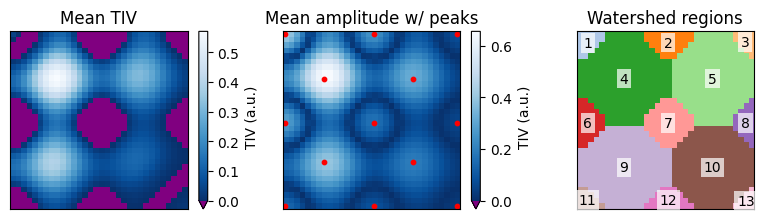

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.3))

captures["mean tiv"].plotting.imshow(ax=axes[0])
axes[0].set(title="Mean TIV")

captures["mean amplitude"].plotting.imshow(ax=axes[1])
peaks = captures["local peaks"]
axes[1].axes.scatter(peaks[:, 1], peaks[:, 0], color="red", s=10, label="local peaks")
axes[1].set(title="Mean amplitude w/ peaks")

watershed_map = captures["watershed regions"]
watershed_map.plotting.imshow(ax=axes[2], colorbar=False)
watershed_map.plotting.add_region_markers(ax=axes[2])

axes[2].set(title="Watershed regions")

fig.tight_layout()

print("Included regions: ", captures["included marker indices"].astype(int))

## Apply the mask to the TIV/amplitude data

The mask is applied to the mean TIV and mean amplitude generated in the previous step. The mask can be applied to 

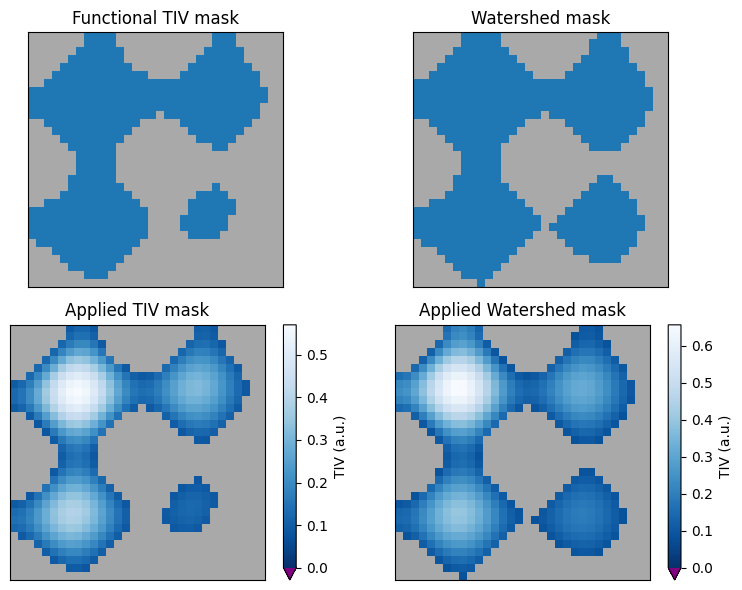

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

mean_amplitude = captures["mean amplitude"]
masked_amplitude = watershed_mask.apply(mean_amplitude)

mean_tiv = captures["mean tiv"]
functional_tiv_mask = captures["functional tiv mask"]
masked_tiv = functional_tiv_mask.apply(mean_tiv)

functional_tiv_mask.plotting.imshow(ax=axes[0, 0])
axes[0, 0].set(title="Functional TIV mask")

watershed_mask.plotting.imshow(ax=axes[0, 1])
axes[0, 1].set(title="Watershed mask")

masked_tiv.plotting.imshow(ax=axes[1, 0])
axes[1, 0].set(title="Applied TIV mask")

masked_amplitude.plotting.imshow(ax=axes[1, 1])
axes[1, 1].set(title="Applied Watershed mask")

fig.tight_layout()